# Add Libraries

In [60]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import seaborn as sns

plt.rcParams.update({
    'font.size': 8,          # Default font size
    'axes.titlesize': 10,    # Title font size
    'axes.labelsize': 9,     # Axis labels font size
    'xtick.labelsize': 8,    # X-axis tick labels font size
    'ytick.labelsize': 8,    # Y-axis tick labels font size
    'legend.fontsize': 8,    # Legend font size
    'figure.titlesize': 10   # Figure title font size
})
plt.rcParams['font.family'] = 'sans-serif'

AcD_color = plt.cm.Pastel1(3)
AcD_error_color = plt.cm.Paired(9)
nonAcD_color = plt.cm.Pastel2(5)
nonAcD_error_color = plt.cm.tab20b(9)

# Set the Results folder address

In [2]:
exp_name = "rewiring_ex1"
exp_result_name_folder = 'wake_state'

simulation_list_date = os.listdir(f'results/{exp_name}/{exp_result_name_folder}')
if '.ipynb_checkpoints' in simulation_list_date:
    simulation_list_date.remove('.ipynb_checkpoints') 
simulation_list_date.sort()

simulation_list_date = ["241117_145956"]

num_branches = 3
cell_num = 100
time_length = int(0.95*1000)
cuttime = int(time_length*0.98)

assembly_number = 9
assembly_size = 30
num_branches = 3

# Calculate the Parameters for Plotting

In [3]:
trials = len(simulation_list_date)

all_trials_cell_connections_AcD = []
all_trials_cell_connections_nonAcD = []

all_trials_brsum_connections_AcD = []
all_trials_brsum_connections_nonAcD = []

all_trials_brsingle_connections_AcD = []
all_trials_brsingle_connections_nonAcD = []

all_trials_mean_weights_AcD = []
all_trials_mean_weights_nonAcD = []

AcD_spikes_list = []
nonAcD_spikes_list = []
#########################################
for trial_num in range(trials):
    cell_Nsyn_T = []
    cell_W_T = []
    cell_mean_W_T = []
    for cell_ind in range(cell_num):
        sim_date = f"{simulation_list_date[trial_num]}/{trial_num}"
        input_directory = os.path.join("results", exp_name,exp_result_name_folder, sim_date, "data","cell_recording",f"cell_num_{cell_ind}")

        with open(os.path.join(input_directory, "weights.0.dat"), "rb") as f:
                lines = f.readlines()
        lines = lines[2:]

        time_series =np.arange(0,int(time_length/0.3),3)
        W_T = []
        Nsyn_T= []
        mean_W_T = []
        for q in time_series:
            weights_t = np.loadtxt(lines[(num_branches+1)*q +1:(num_branches+1)*(q+1)])
            weight_br_assemb = np.zeros((num_branches,assembly_number))
            Nsyn_br_assemb = np.zeros((num_branches,assembly_number))
            Nsyn_br = np.zeros((num_branches))
            mean_weight = np.zeros((num_branches,assembly_number))
            for j in range(num_branches):
                for i in range(assembly_number):
                    weight_br_assemb[j][i] = np.sum(weights_t[j][i * assembly_size:(i+1)*assembly_size])
                    Nsyn_br_assemb[j][i] = len(np.where(weights_t[j][i * assembly_size:(i+1)*assembly_size] > 0)[0])
                    mean_weight[j][i] = weight_br_assemb[j][i] / Nsyn_br_assemb[j][i]
                Nsyn_br[j] = len(np.where(weights_t[j] > 0.5)[0])
            W_T.append(weight_br_assemb)
            Nsyn_T.append(Nsyn_br)
            mean_W_T.append(mean_weight)
        W_T = np.array(W_T)
        mean_W_T = np.array(mean_W_T)
        Nsyn_T = np.array(Nsyn_T)
        Nsyn_T = Nsyn_T.T
        cell_Nsyn_T.append(np.mean(Nsyn_T[:,-cuttime:],axis = 1))
        cell_W_T.append(np.mean(W_T[-cuttime:,:,:],axis = 0))
        cell_mean_W_T.append(np.mean(mean_W_T[-cuttime:,:,:],axis = 0))
        
        #### d-spikes
        if cell_ind < cell_num/2:
            for br_ind in range(num_branches):
                with open(f'{input_directory}/branch{br_ind}.0.mem', 'r') as f:
                    data_observed = f.read().splitlines(True)

                potential_stick = [] 
                obsevation_time = []
                for component in data_observed[1:]:
                        comps = component.split(' ')
                        potential_stick.append(float(comps[1]))
                        obsevation_time.append(float(comps[0]))

                obsevation_time = np.array(obsevation_time)
                potential_stick = np.array(potential_stick)
                eq_time_ind = np.where(obsevation_time>=cuttime)[0][0]
                spikes_count = len(np.where(potential_stick[eq_time_ind:] >= -37)[0])
                if br_ind == 0:
                    AcD_d_spike = spikes_count
                elif br_ind == 1 :
                    nonAcD_d_spike_1 = spikes_count
                else:
                    nonAcD_d_spike_2 = spikes_count
            
            AcD_spikes_list.append(AcD_d_spike/(AcD_d_spike+np.mean([nonAcD_d_spike_1,nonAcD_d_spike_2]))*100)
            nonAcD_spikes_list.append(np.mean([nonAcD_d_spike_1,nonAcD_d_spike_2])/(AcD_d_spike+np.mean([nonAcD_d_spike_1,nonAcD_d_spike_2]))*100)#/(AcD_d_spike+nonAcD_d_spike_1+nonAcD_d_spike_2)*100)

        
    cell_Nsyn_T = np.array(cell_Nsyn_T)
    cell_W_T = np.array(cell_W_T)
    cell_mean_W_T = np.array(cell_mean_W_T)
    cell_mean_W_T = np.nan_to_num(cell_mean_W_T)
    
    AcD_mean_weights = cell_mean_W_T[:int(cell_num/2),0,:].flatten()
    AcD_mean_weights = AcD_mean_weights[AcD_mean_weights>0]
    nonAcD_mean_weights = np.append(cell_mean_W_T[:int(cell_num/2),1:,:].flatten() , cell_mean_W_T[int(cell_num/2):,:,:].flatten())
    nonAcD_mean_weights = nonAcD_mean_weights[nonAcD_mean_weights>0]
    
################## MEANS#####################    
#     all_trials_cell_connections_AcD.append(np.mean(np.sum(cell_Nsyn_T[:int(cell_num/2)],axis = 1)))
#     all_trials_cell_connections_nonAcD.append(np.mean(np.sum(cell_Nsyn_T[int(cell_num/2):],axis = 1)))
    
#     all_trials_brsum_connections_AcD.append(np.mean(cell_Nsyn_T[:int(cell_num/2),0]))
#     all_trials_brsum_connections_nonAcD.append(np.mean(np.sum(cell_Nsyn_T[:int(cell_num/2),1:],axis = 1)))
    
#     all_trials_brsingle_connections_AcD.append(np.mean(cell_Nsyn_T[:int(cell_num/2),0]))
#     all_trials_brsingle_connections_nonAcD.append(np.mean(cell_Nsyn_T[:int(cell_num/2),1:]))

#     all_trials_mean_weights_AcD.append(np.mean(AcD_mean_weights))
#     all_trials_mean_weights_nonAcD.append(np.mean(nonAcD_mean_weights))
#######################################
################## all data #####################    
    
    all_trials_cell_connections_AcD.append(np.sum(cell_Nsyn_T[:int(cell_num/2)],axis = 1).flatten())
    all_trials_cell_connections_nonAcD.append(np.sum(cell_Nsyn_T[int(cell_num/2):],axis = 1).flatten())
    
    all_trials_brsum_connections_AcD.append(cell_Nsyn_T[:int(cell_num/2),0].flatten())
    all_trials_brsum_connections_nonAcD.append(np.sum(cell_Nsyn_T[:int(cell_num/2),1:],axis = 1).flatten())
    
    all_trials_brsingle_connections_AcD.append(cell_Nsyn_T[:int(cell_num/2),0].flatten())
    all_trials_brsingle_connections_nonAcD.append(cell_Nsyn_T[:int(cell_num/2),1:].flatten())

    all_trials_mean_weights_AcD.append(AcD_mean_weights.flatten())
    all_trials_mean_weights_nonAcD.append(nonAcD_mean_weights.flatten())
    
all_trials_mean_weights_AcD = np.concatenate(all_trials_mean_weights_AcD)
all_trials_mean_weights_nonAcD = np.concatenate(all_trials_mean_weights_nonAcD)


/var/folders/rj/mk57hg8s74l0y1xwws2ss9k40000gn/T/ipykernel_8417/1348741024.py:44: RuntimeWarning: invalid value encountered in double_scalars
  mean_weight[j][i] = weight_br_assemb[j][i] / Nsyn_br_assemb[j][i]


# Plotting

## Number of connections

In [41]:
np.mean(all_trials_cell_connections_AcD)
np.sqrt(all_trials_cell_connections_AcD)
all_trials_cell_connections_AcD[0]


array([31.82814178, 36.98603652, 34.58646617, 33.62835661, 35.25134264,
       36.91084855, 34.81632653, 30.37056928, 33.6122449 , 32.78195489,
       32.70139635, 35.23737916, 35.31578947, 31.81095596, 33.84854995,
       33.60365199, 36.09667025, 34.82062299, 32.51020408, 36.19548872,
       35.64232009, 34.90332975, 35.52094522, 34.64876477, 34.76691729,
       34.85714286, 36.08270677, 32.35767991, 31.70784103, 36.48442535,
       34.71106337, 34.28571429, 34.33512352, 35.3329753 , 34.04833512,
       36.03544576, 32.82277121, 34.25456498, 36.43179377, 34.867884  ,
       34.90225564, 37.17615467, 32.01718582, 35.90547798, 34.43071966,
       34.87325456, 35.52524168, 34.0461869 , 36.91729323, 33.94629431])

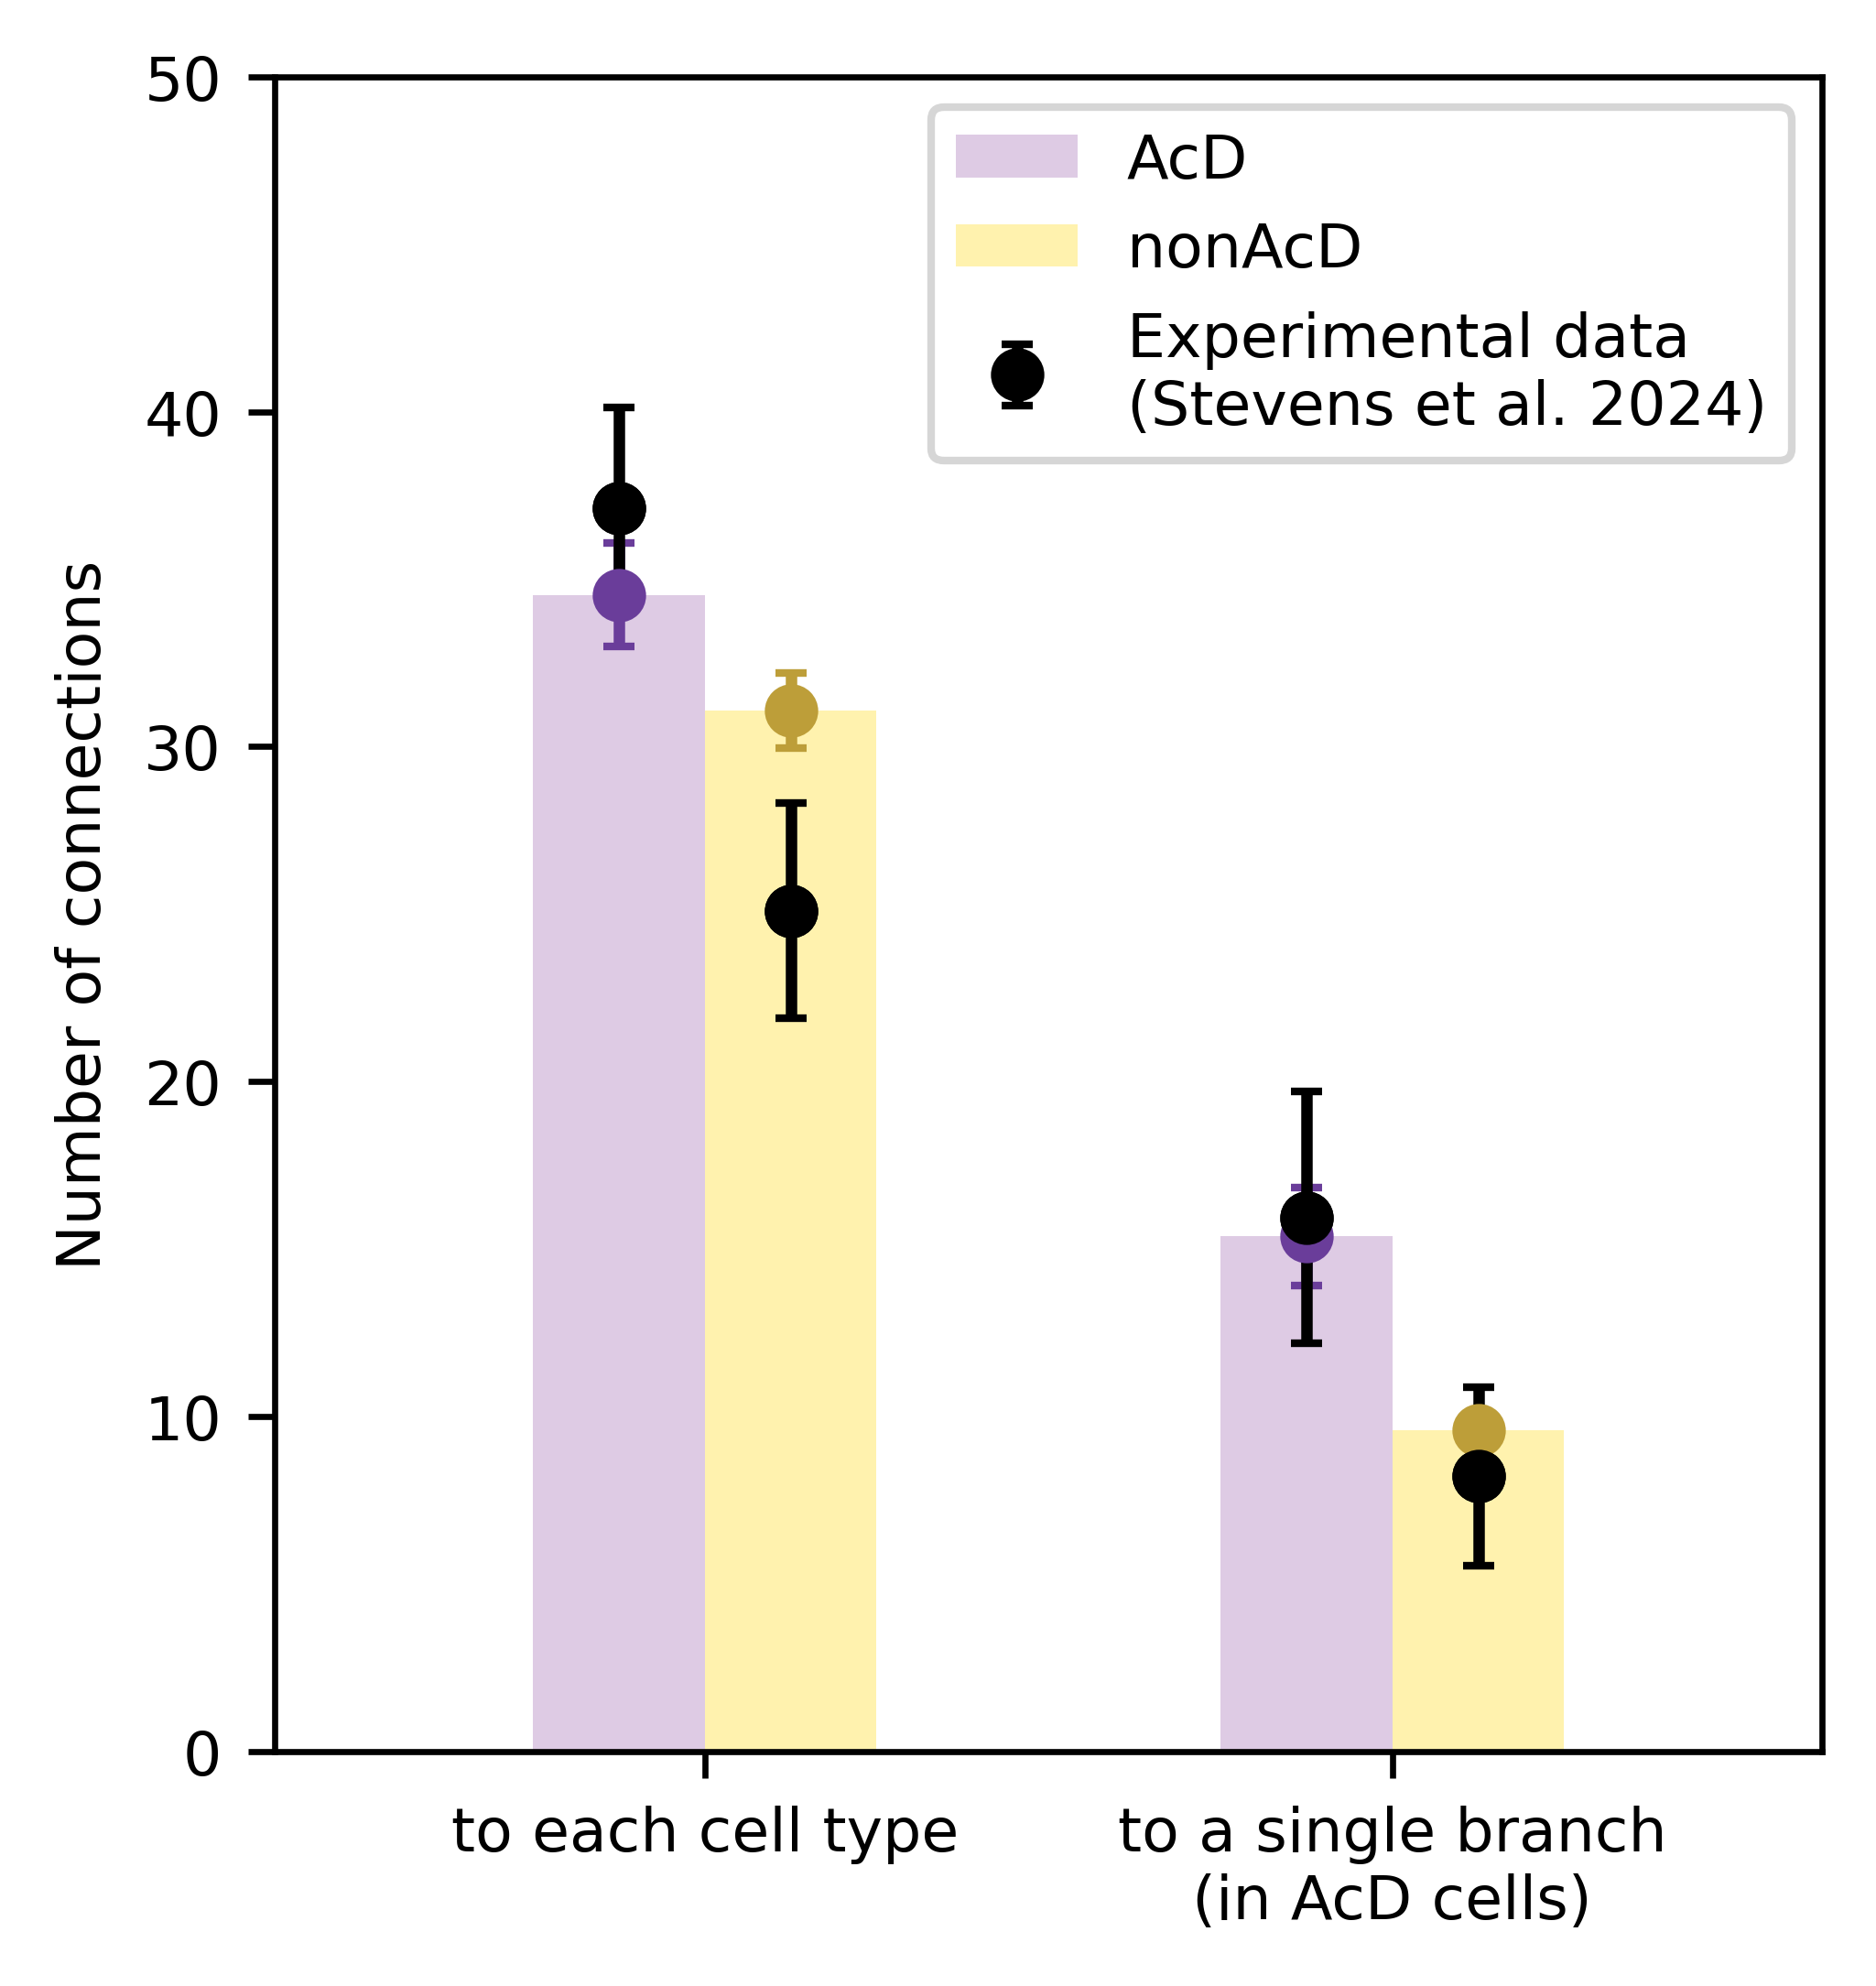

In [82]:
##########plotting########
fig, axs = plt.subplots(figsize=(3.3, 3.5), dpi=600,constrained_layout = True)
x_pos = [[0.45,0.55],[0.85,0.95]]
width_len = 0.1
color_plot = [plt.cm.Pastel1(3),plt.cm.Pastel1(4),'black']
###AcD cell vs. non-AcD cell
axs.bar(x_pos[0][0], np.mean(all_trials_cell_connections_AcD), width_len,color = AcD_color,label ="AcD")
# axs.fill_between(np.linspace(x_pos[0][0]-width_len/2,x_pos[0][0]+width_len/2,1000), 
#                  np.mean(all_trials_cell_connections_AcD)-np.std(all_trials_cell_connections_AcD), 
#                  np.mean(all_trials_cell_connections_AcD)+np.std(all_trials_cell_connections_AcD),
#                  alpha = 0.4,color= color_plot[0])
axs.errorbar(x_pos[0][0], np.mean(all_trials_cell_connections_AcD), yerr=np.std(all_trials_cell_connections_AcD),color=AcD_error_color,fmt = "o",capsize =2)

axs.bar(x_pos[0][1], np.mean(all_trials_cell_connections_nonAcD), width_len,color = nonAcD_color, label = "nonAcD")
# axs.fill_between(np.linspace(x_pos[0][1]-width_len/2,x_pos[0][1]+width_len/2,1000), 
#                  np.mean(all_trials_cell_connections_nonAcD)-np.std(all_trials_cell_connections_nonAcD), 
#                  np.mean(all_trials_cell_connections_nonAcD)+np.std(all_trials_cell_connections_nonAcD),
#                  alpha = 0.4,color= color_plot[1])
axs.errorbar(x_pos[0][1], np.mean(all_trials_cell_connections_nonAcD), yerr=np.std(all_trials_cell_connections_nonAcD),color=nonAcD_error_color,fmt = "o",capsize =2)




##################################################
###in AcD cells : AcD branch vs. non-AcD branch
axs.bar(x_pos[1][0], np.mean(all_trials_brsingle_connections_AcD), width_len,color = AcD_color)
# axs.fill_between(np.linspace(x_pos[1][0]-width_len/2,x_pos[1][0]+width_len/2,1000), 
#                  np.mean(all_trials_brsingle_connections_AcD)-np.std(all_trials_brsingle_connections_AcD), 
#                  np.mean(all_trials_brsingle_connections_AcD)+np.std(all_trials_brsingle_connections_AcD),
#                  alpha = 0.4,color= color_plot[0])
axs.errorbar(x_pos[1][0], np.mean(all_trials_brsingle_connections_AcD), yerr=np.std(all_trials_brsingle_connections_AcD),color=AcD_error_color,fmt = "o",capsize =2)

axs.bar(x_pos[1][1], np.mean(all_trials_brsingle_connections_nonAcD), width_len,color = nonAcD_color)
# axs.fill_between(np.linspace(x_pos[1][1]-width_len/2,x_pos[1][1]+width_len/2,1000), 
#                  np.mean(all_trials_brsingle_connections_nonAcD)-np.std(all_trials_brsingle_connections_nonAcD), 
#                  np.mean(all_trials_brsingle_connections_nonAcD)+np.std(all_trials_brsingle_connections_nonAcD),
#                  alpha = 0.4,color= color_plot[1])

axs.errorbar(x_pos[1][1], np.mean(all_trials_brsingle_connections_nonAcD), yerr=np.std(all_trials_brsingle_connections_nonAcD),color=nonAcD_error_color,fmt = "o",capsize =2)



################# Stevens data
axs.errorbar(x_pos[0][0], 37.12, yerr=np.sqrt(9.00),color=color_plot[2],fmt = "o",label ="Experimental data\n(Stevens et al. 2024)",capsize =2)
axs.scatter(x_pos[0][0], 37.12, marker = "o", color = color_plot[2] )

axs.errorbar(x_pos[0][1], 25.10, yerr=np.sqrt(10.35),color=color_plot[2],fmt = "o",capsize =2)
axs.scatter(x_pos[0][1], 25.10, marker = "o", color = color_plot[2] )

axs.errorbar(x_pos[1][0], 15.94, yerr=np.sqrt(14.18),color=color_plot[2],fmt = "o",capsize =2)
axs.scatter(x_pos[1][0], 15.94, marker = "o", color = color_plot[2] )

axs.errorbar(x_pos[1][1], 8.21, yerr=np.sqrt(7.15),color=color_plot[2],fmt = "o",capsize =2)
axs.scatter(x_pos[1][1], 8.21, marker = "o", color = color_plot[2] )



axs.set_xticks([np.mean(x_pos[0]),np.mean(x_pos[1])],["to each cell type","to a single branch\n(in AcD cells)"])
axs.set_yticks([0,10,20,30,40,50],['0','10','20','30','40','50'])
axs.set_ylabel("Number of connections")
# axs.set_ylim(0,80)
axs.legend()
axs.set_xlim(x_pos[0][0]-2*width_len,x_pos[1][1]+2*width_len)


plt.savefig("Figures/pdf/count_connections.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Figures/svg/count_connections.svg", format='svg', bbox_inches='tight')


## Synaptic weights

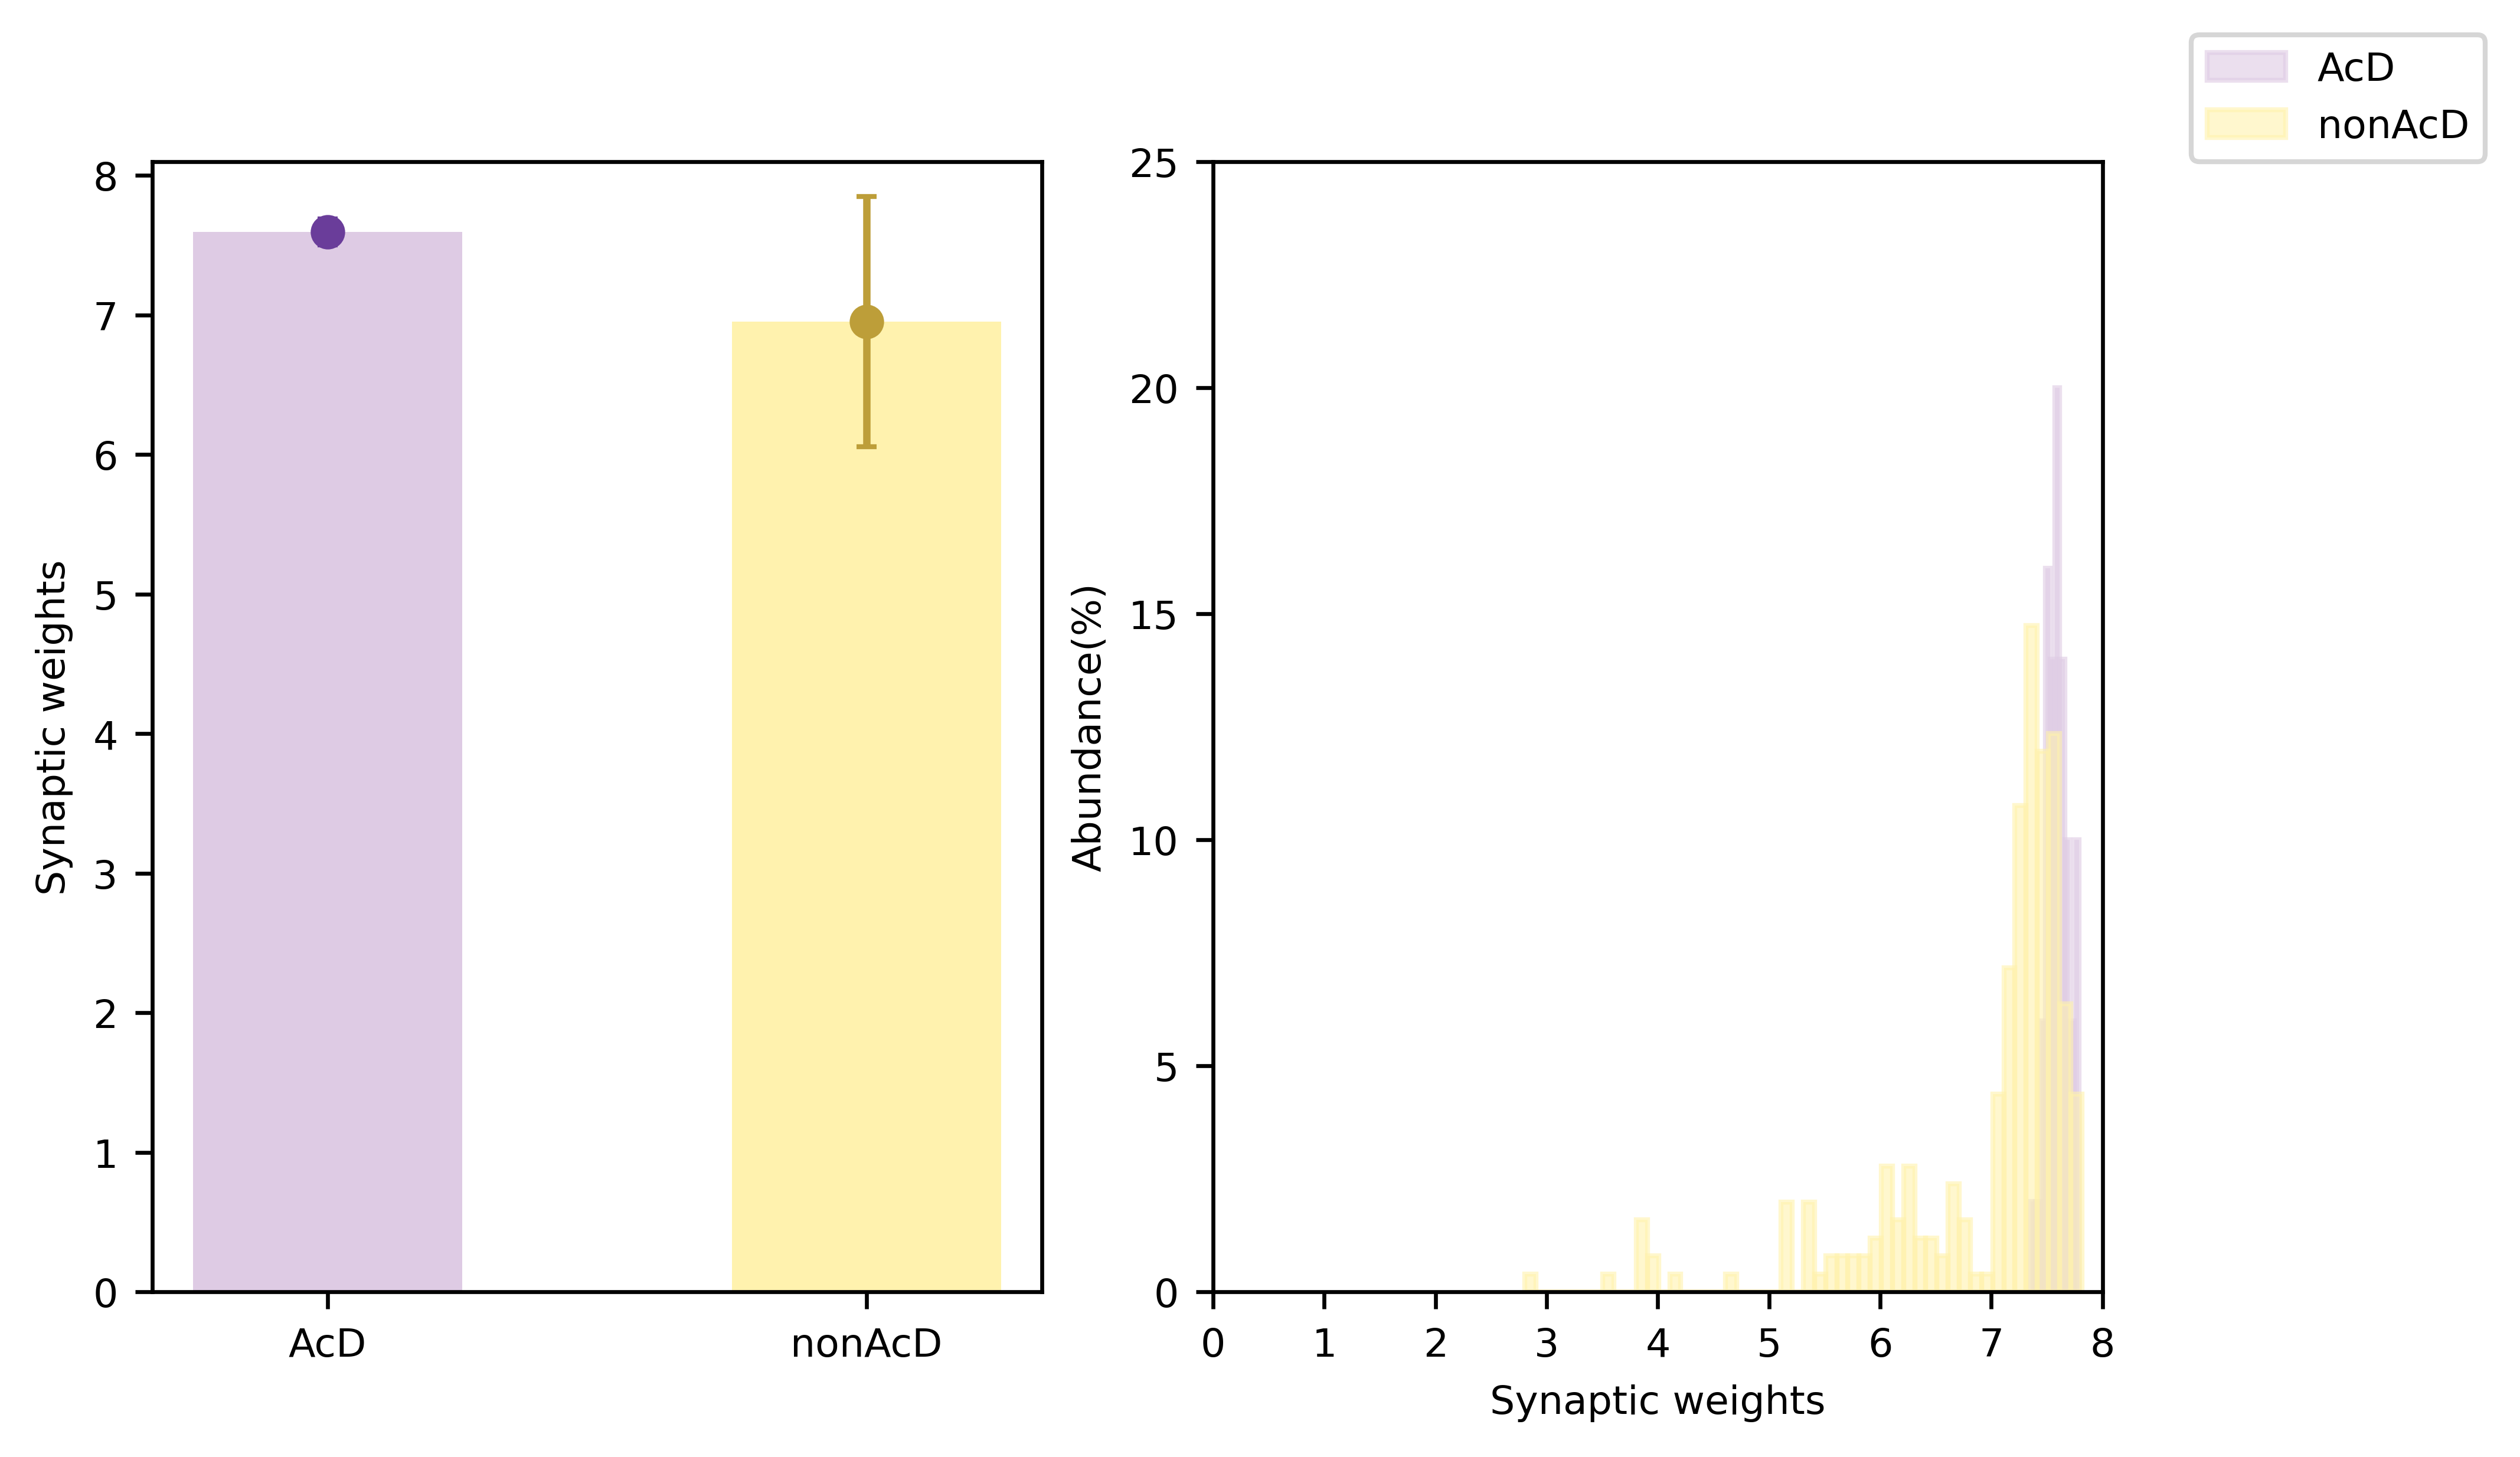

In [81]:
fig, axs = plt.subplots(1,2,figsize=(7, 4), dpi=600,constrained_layout = True)

x_pos = [0.2,0.4]
color_plot = [plt.cm.Pastel1(3),plt.cm.Pastel1(4)]
width_len = 0.1
############################
axs[0].bar(x_pos[0], np.mean(all_trials_mean_weights_AcD), width_len ,color = AcD_color,label ="AcD")
# axs[0].fill_between(np.linspace(x_pos[0]-width_len/2,x_pos[0]+width_len/2,1000),
#                     np.maximum(np.mean(all_trials_mean_weights_AcD)-np.std(all_trials_mean_weights_AcD),0),
#                     np.minimum(np.mean(all_trials_mean_weights_AcD)+np.std(all_trials_mean_weights_AcD),8),
#                     alpha = 0.3,color= color_plot[0])
axs[0].errorbar(x_pos[0], np.mean(all_trials_mean_weights_AcD), yerr=np.std(all_trials_mean_weights_AcD),color=AcD_error_color,fmt = "o",capsize =2)



axs[0].bar(x_pos[1], np.mean(all_trials_mean_weights_nonAcD), width_len,color = nonAcD_color, label = "nonAcD")
# axs[0].fill_between(np.linspace(x_pos[1]-width_len/2,x_pos[1]+width_len/2,1000),
#                     np.maximum(np.mean(all_trials_mean_weights_nonAcD)-np.std(all_trials_mean_weights_nonAcD),0),
#                     np.minimum(np.mean(all_trials_mean_weights_nonAcD)+np.std(all_trials_mean_weights_nonAcD),8),
#                     alpha = 0.3,color= color_plot[1])
axs[0].errorbar(x_pos[1], np.mean(all_trials_mean_weights_nonAcD), yerr=np.std(all_trials_mean_weights_nonAcD),color=nonAcD_error_color,fmt = "o",capsize =2)


axs[0].set_xticks(x_pos,["AcD","nonAcD"])
axs[0].set_yticks(np.arange(9))

axs[0].set_ylabel("Synaptic weights")
axs[0].set_ylim(0,8.1)
###########################


counts, bin_edges = np.histogram(all_trials_mean_weights_AcD, bins=10)
relative_frequencies = counts / counts.sum()  # Relative frequencies
percentage_frequencies = relative_frequencies * 100  # Convert to percentage
axs[1].bar(bin_edges[:-1], percentage_frequencies, width=np.diff(bin_edges), edgecolor=AcD_color, color=AcD_color, align='edge',alpha = 0.6,label='AcD')

counts, bin_edges = np.histogram(all_trials_mean_weights_nonAcD, bins=50)
relative_frequencies = counts / counts.sum()  # Relative frequencies
percentage_frequencies = relative_frequencies * 100  # Convert to percentage
axs[1].bar(bin_edges[:-1], percentage_frequencies, width=np.diff(bin_edges), edgecolor=nonAcD_color, color=nonAcD_color, align='edge',alpha = 0.6,label='nonAcD')
axs[1].set_ylim(0,25.0)



axs[1].set_xlim(0,8.0)
axs[1].set_xlabel("Synaptic weights")
axs[1].set_ylabel("Abundance(%)")
axs[1].set_xticks(np.arange(9))
# axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[1].legend(loc=(1.1,1))


plt.savefig("Figures/pdf/weights_population.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Figures/svg/weights_population.svg", format='svg', bbox_inches='tight')


## Number of dendritic spikes

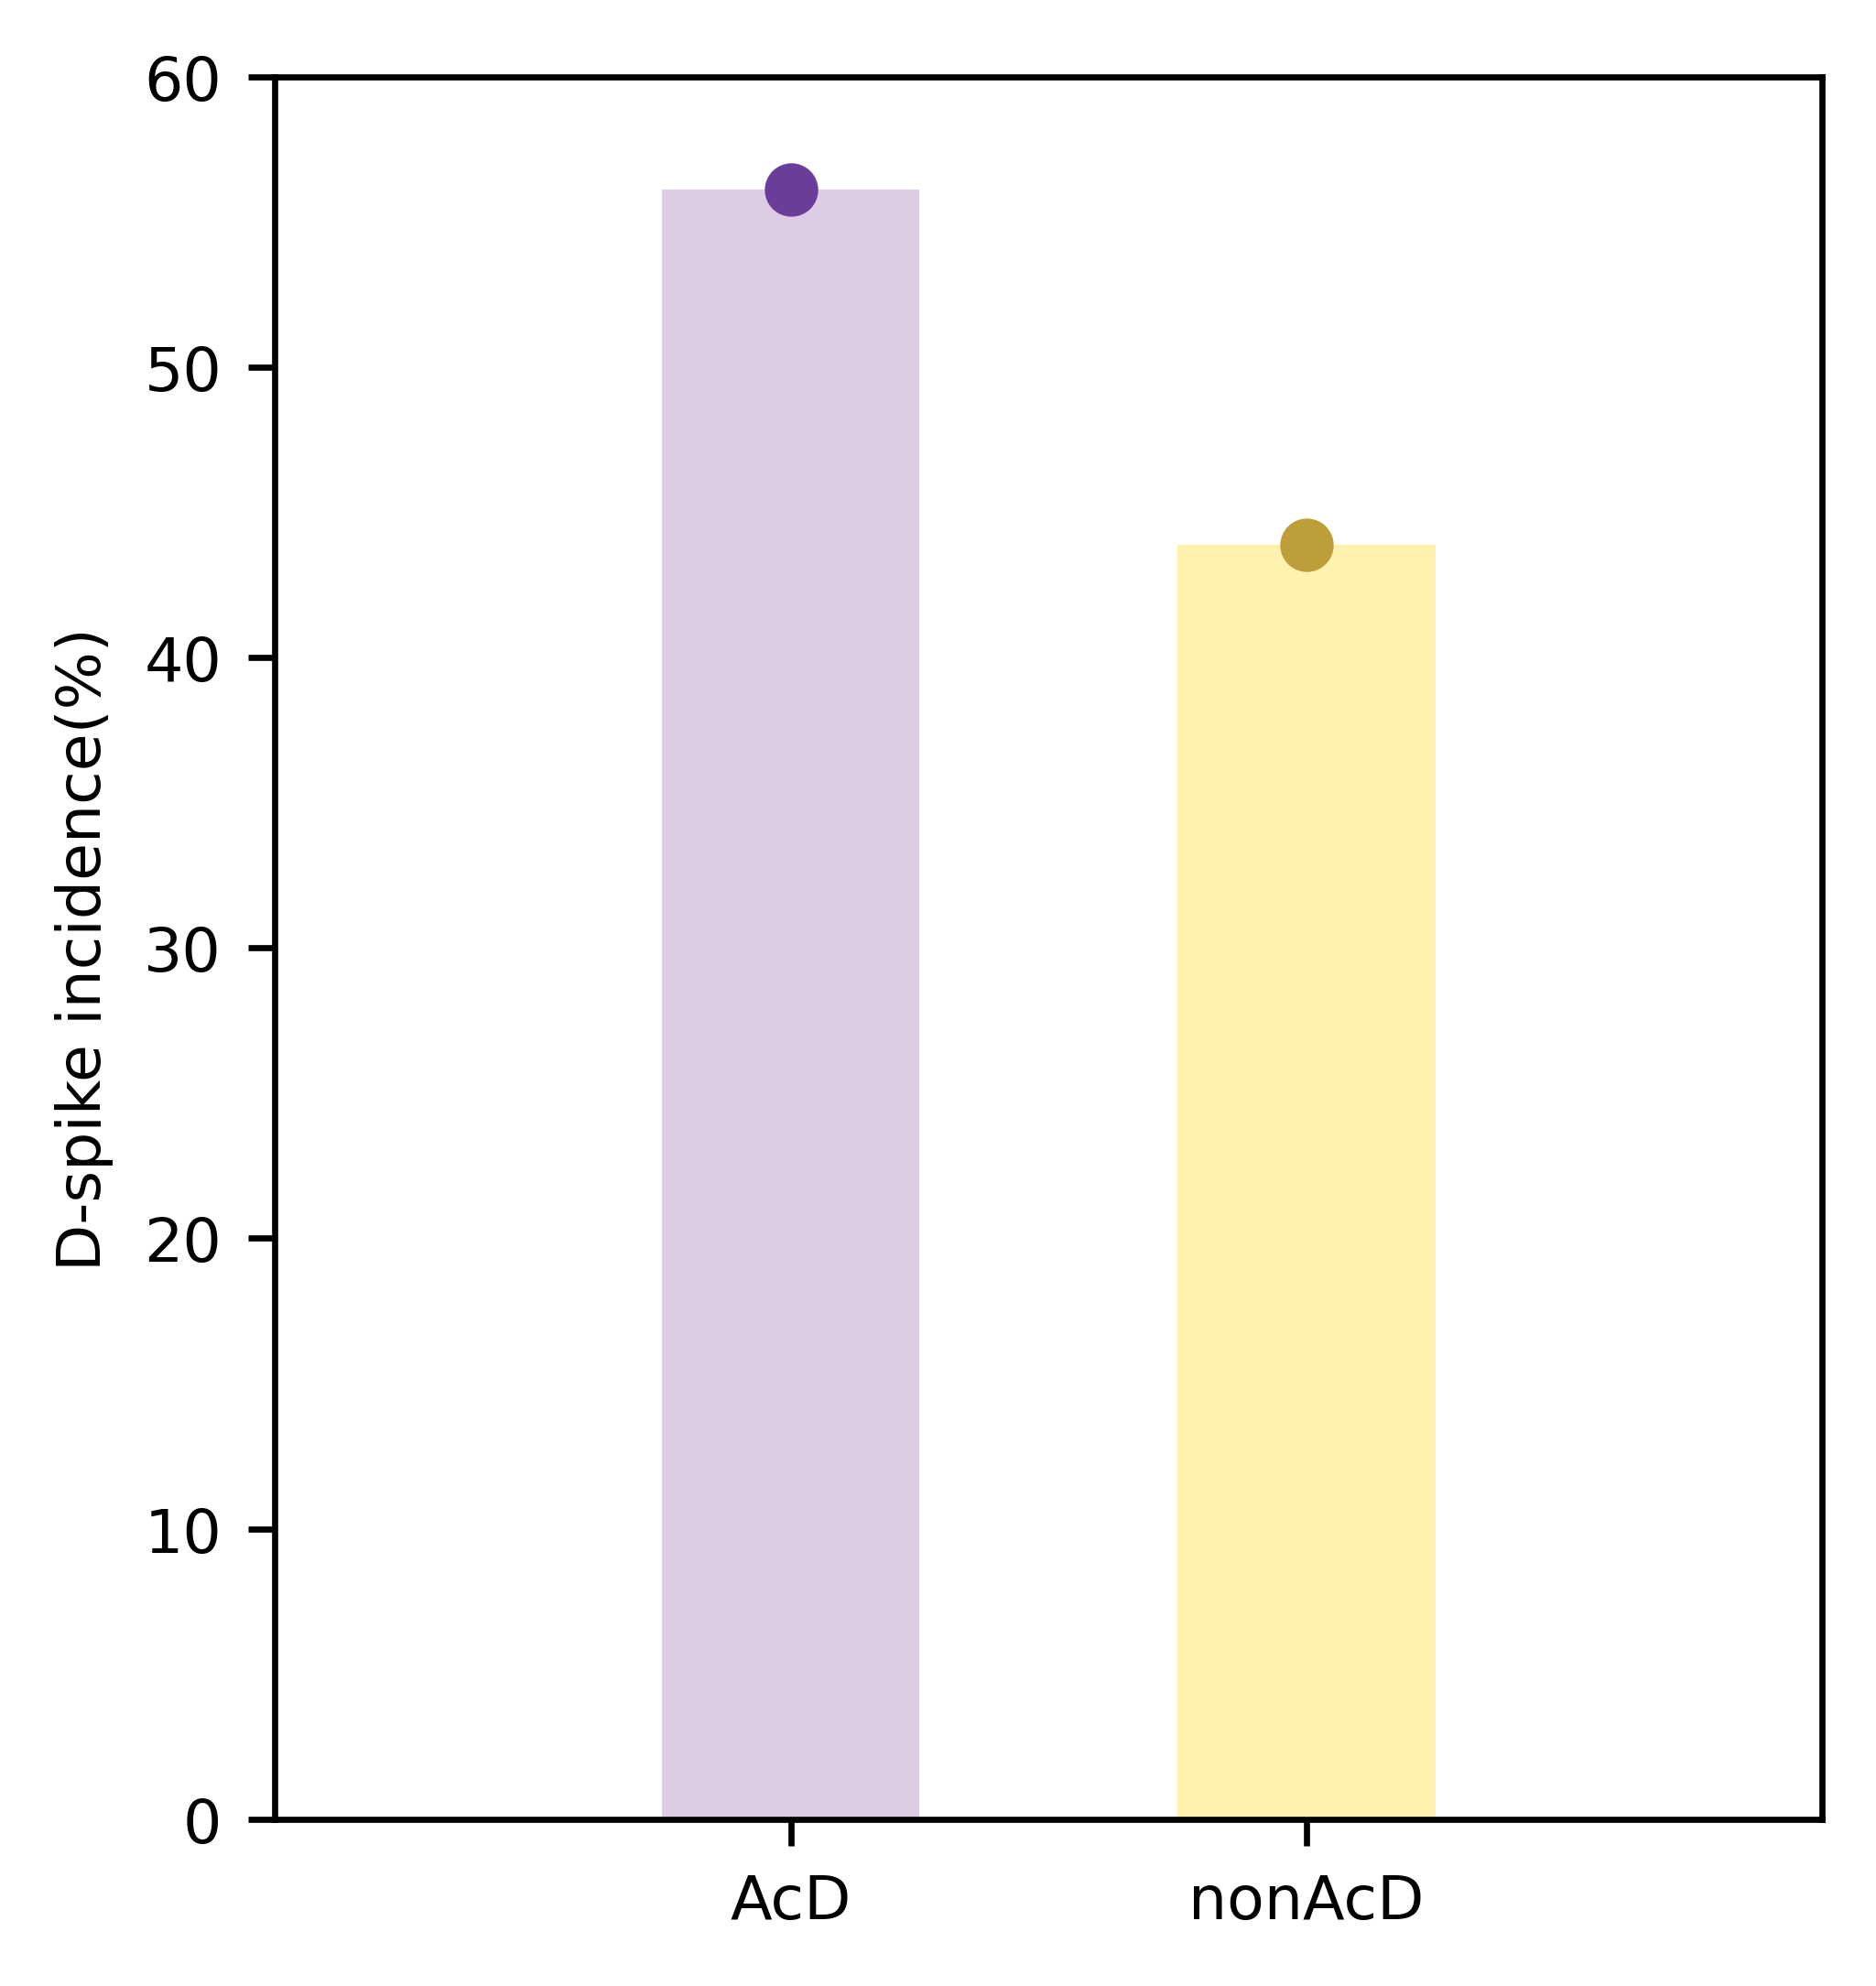

In [80]:
fig, axs = plt.subplots(figsize=(3.3, 3.5), dpi=600,constrained_layout = True)
x_pos = [0.5,0.6]
width_len = 0.05
color_plot = [plt.cm.Pastel1(3),plt.cm.Pastel1(4),'black']
axs.bar(x_pos[0],np.mean(AcD_spikes_list), width = width_len,color = AcD_color)


axs.errorbar(x_pos[0], np.mean(AcD_spikes_list), yerr=np.std(AcD_spikes_list),color=AcD_error_color,fmt = "o",capsize =2)

axs.bar(x_pos[1],np.mean(nonAcD_spikes_list), width = width_len,color = nonAcD_color)

axs.errorbar(x_pos[1], np.mean(nonAcD_spikes_list), yerr=np.std(nonAcD_spikes_list),color=nonAcD_error_color,fmt = "o",capsize =2)


axs.set_xticks(x_pos,['AcD','nonAcD'])
axs.set_ylabel('D-spike incidence(%)')
axs.set_xlim(x_pos[0] -2*width_len ,x_pos[-1] + 2*width_len)
axs.set_ylim(0,60)

plt.savefig("Figures/pdf/dendritic_spikes.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Figures/svg/dendritic_spikes.svg", format='svg', bbox_inches='tight')
